In [18]:
from keras.models import Sequential
import keras
import tensorflow as tf
import numpy as np

#MNIST: loading, splitting, and reshaping

In [41]:
mnist = keras.datasets.mnist

(training_images, training_labels), (test_images, test_labels) = mnist.load_data()
training_images=training_images.reshape(60000, 28, 28, 1)
training_images=training_images / 255.0
test_images = test_images.reshape(10000, 28, 28, 1)
test_images=test_images/255.0

In [42]:
# All the target value '5' = 1, and all others = 0
test_labels = np.where(test_labels == 5, 1, 0)
training_labels = np.where(training_labels == 5, 1, 0)

num_of_5s = len(training_labels[training_labels == 1])
print(f'number of class=5 in dataset: {num_of_5s}')
print(f'percentage of class=5 in dataset: {round(num_of_5s/len(training_labels), 3) * 100}%')

number of class=5 in dataset: 5421
percentage of class=5 in dataset: 9.0%


# Model Changes 
The main motivation was to convert the model into a class. This 
will help with reusability and modularity. 
I also wanted to add some features that are standard in any modern machine learning model.
Here are the things I added to improve generalization:
- l2 regularization for both the bias and kernel
- he weight initialization 
- Learning rate scheduler

I also added a new conv2dlayer, which helped improve the score.

In [21]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras.initializers import HeNormal
from keras.regularizers import l2
from keras.callbacks import LearningRateScheduler
from keras.optimizers.schedules import ExponentialDecay
from keras.layers import Dropout
from sklearn.base import BaseEstimator, ClassifierMixin


class MNISTModel(BaseEstimator, ClassifierMixin):
    def __init__(self):
        self.model = Sequential([
            self.Conv2DLayer(16),
            self.Conv2DLayer(32),
            MaxPooling2D(2, 2),
            Flatten(),
            self.DenseLayer(128, activation='relu'),
            Dropout(0.2),
            self.DenseLayer(10, activation='softmax'),
        ])

    # Customer Conv2D layer
    def Conv2DLayer(self, filters):
        return Conv2D(
            filters=filters, kernel_size=(3,3), activation='relu', 
            input_shape=(28, 28, 1), 
            kernel_initializer=HeNormal(), bias_initializer=HeNormal(),
            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), 
            strides=1, padding='same'
        )
    
    # Customer Dense layer
    def DenseLayer(self, nodes, activation='relu'):
        return Dense(
            nodes, activation=activation, 
            kernel_initializer=HeNormal(), bias_initializer=HeNormal(),
            kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)
        )

    # Resets weights to HeNormal
    def reset_weights(self):
        initial_weights = self.model.get_weights()
        self.model.set_weights(initial_weights)

    # compile the model
    def compile(self):
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Run the model. Forward fit using a learning rate scheduler
    def fit(self, training_images, training_labels, epochs=1, batch_size=32):
        lr_scheduler = ExponentialDecay(initial_learning_rate=0.001, decay_steps=1, decay_rate=.1)
        self.model.fit(training_images, training_labels, epochs=epochs, 
                    batch_size=batch_size, callbacks=[LearningRateScheduler(lr_scheduler)])

# display model summary
model = MNISTModel()
model.model.summary()


In [22]:
# Create and train model 
mnist_model = MNISTModel()
mnist_model.reset_weights() 
mnist_model.compile()
mnist_model.fit(training_images, training_labels, epochs=5, batch_size=32)
mnist_model.model.save('mnist_model.keras')

Epoch 1/5
1875/1875 [==============================] - 35s 18ms/step - loss: 0.4209 - accuracy: 0.9791 - lr: 0.0010
Epoch 2/5
1875/1875 [==============================] - 34s 18ms/step - loss: 0.1546 - accuracy: 0.9881 - lr: 1.0000e-04
Epoch 3/5
1875/1875 [==============================] - 33s 18ms/step - loss: 0.1451 - accuracy: 0.9887 - lr: 1.0000e-05
Epoch 4/5
1875/1875 [==============================] - 35s 18ms/step - loss: 0.1439 - accuracy: 0.9885 - lr: 1.0000e-06
Epoch 5/5
1875/1875 [==============================] - 34s 18ms/step - loss: 0.1439 - accuracy: 0.9890 - lr: 1.0000e-07


313/313 [==============================] - 1s 3ms/step - loss: 0.1365 - accuracy: 0.9905

Model Evaluation
Accuracy: 0.990500
Precision: 0.990439
Recall: 0.990500
f1-score: 0.990337


1/1 [==============================] - 0s 18ms/step
Predicted: 0
Actual: 0
-----------------


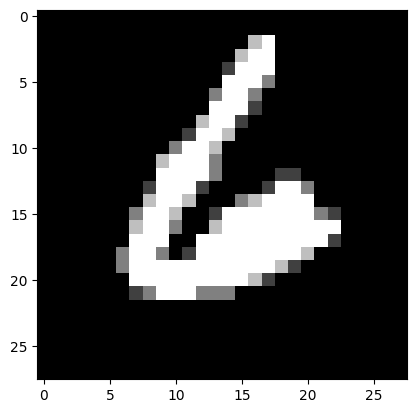

1/1 [==============================] - 0s 21ms/step
Predicted: 0
Actual: 0
-----------------


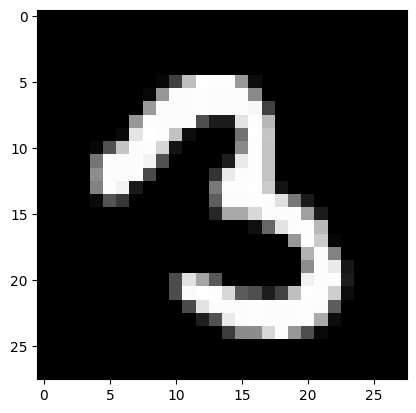

1/1 [==============================] - 0s 13ms/step
Predicted: 1
Actual: 1
-----------------


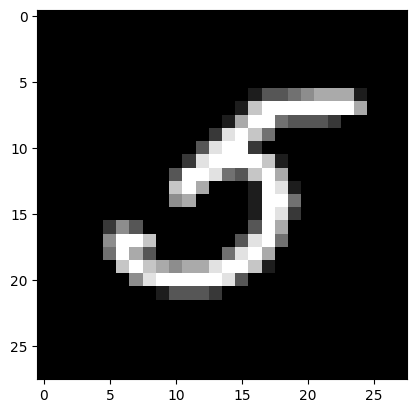

1/1 [==============================] - 0s 13ms/step
Predicted: 1
Actual: 1
-----------------


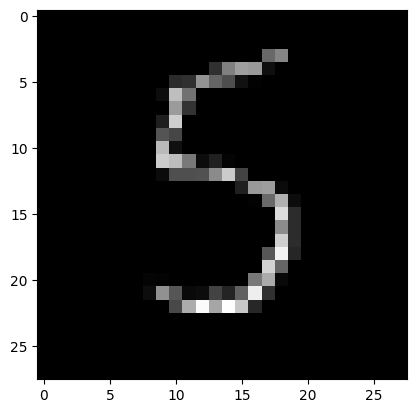

1/1 [==============================] - 0s 13ms/step
Predicted: 0
Actual: 0
-----------------


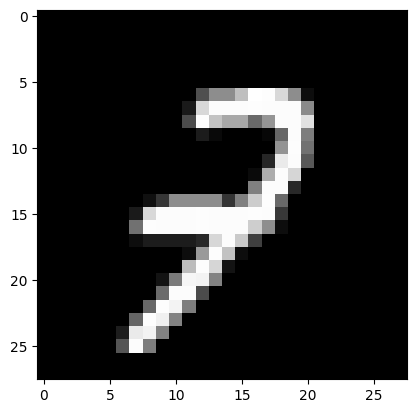

1/1 [==============================] - 0s 14ms/step
Predicted: 0
Actual: 0
-----------------


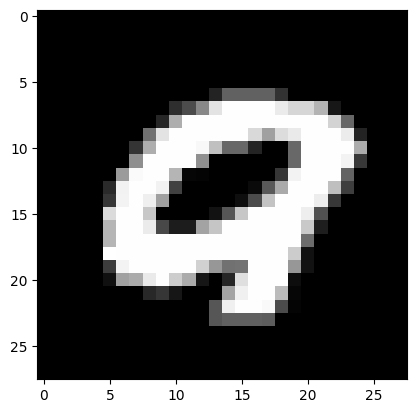

1/1 [==============================] - 0s 14ms/step
Predicted: 0
Actual: 0
-----------------


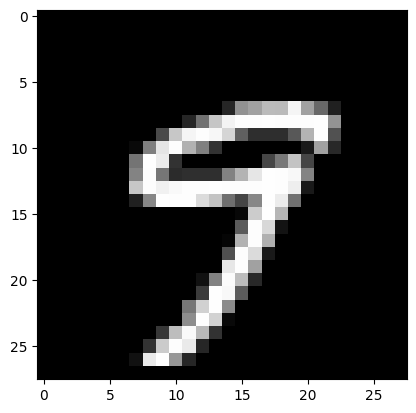

1/1 [==============================] - 0s 14ms/step
Predicted: 0
Actual: 0
-----------------


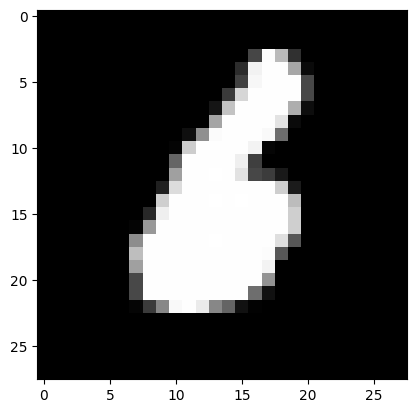

1/1 [==============================] - 0s 15ms/step
Predicted: 0
Actual: 0
-----------------


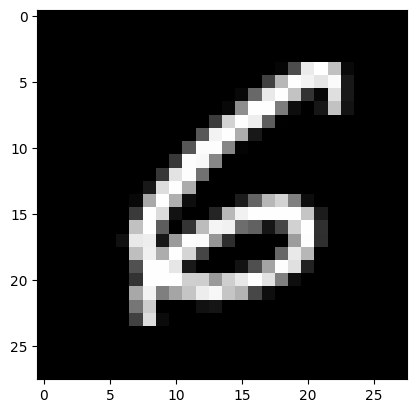

1/1 [==============================] - 0s 15ms/step
Predicted: 0
Actual: 0
-----------------


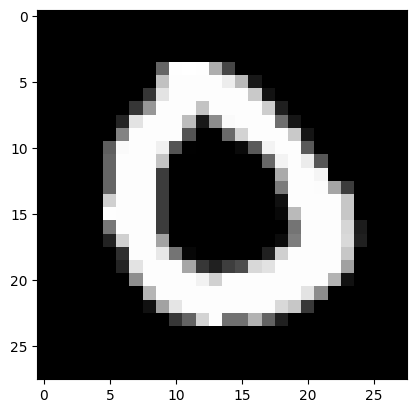

In [56]:
import random
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support

""" Load the model and evaluate it on the test data """
model = keras.models.load_model('mnist_model.keras')
# Get the predictions and get the maximum prediction
y_pred = model.predict(test_images)
y_pred = np.argmax(y_pred, axis=1)
# Get the loss and accuracy
loss, accuracy = model.evaluate(test_images, test_labels)
precision, recall, fscore, support = precision_recall_fscore_support(
    test_labels, y_pred, average='weighted')

print('\nModel Evaluation')
print(f'Accuracy: {accuracy:2f}')
print(f'Precision: {precision:2f}')
print(f'Recall: {recall:2f}')
print(f'f1-score: {fscore:2f}\n\n')


""" Visualize 10 random test samples, their predicted labels and their actual labels"""
for i in range(10):
    index = random.randint(0, len(test_images))
    image = test_images[index]
    label = test_labels[index]
    prediction = model.predict(image.reshape(1, 28, 28, 1))
    print(f'Predicted: {np.argmax(prediction)}')
    print(f'Actual: {label}')
    print('-----------------')
    plt.imshow(image.reshape(28, 28), cmap='gray')
    plt.show()

